# Hull Tactical Market Prediction

### Import Libralies

In [17]:
# Utilities
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization
from colorama import Fore, Style
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# Models
import lightgbm as lgb

# Submission
import polars as pl
import kaggle_evaluation.default_inference_server

In [18]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [19]:
INNER_VAL_LEN = 180
TRADING_DAYS_PER_YR = 252

### Definition

In [20]:
# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 7.5                 # Multiplier of the OLS market forward excess returns predictions to signal

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters,
    signal_multiplier=None
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """

    # 予測値を基準に，投資戦略シグナルに変換
    # ret * signal_multiplier + 1 を min_signal ~ max_signal の範囲にクリップ
    if signal_multiplier is None:
        multi = params.signal_multiplier
    else:
        multi = signal_multiplier

    ret = np.clip(
        ret_arr * multi + 1,
        params.min_signal,
        params.max_signal
    )

    if ret.size < 20:
        print(f"Strategy:")
        for i, value in enumerate(ret): print(f'  {i}: {value:.4f}')

    return ret

In [21]:
# convert_ret_to_signalの動作確認
# 20個の乱数(0~1)
hoge = convert_ret_to_signal(np.array([5, 0.1, 0.3, -0.2, 1.3]), ret_signal_params)

Strategy:
  0: 2.0000
  1: 1.7500
  2: 2.0000
  3: 0.0000
  4: 2.0000


In [22]:
# ============ LOAD DATA ============
# プラットフォームがkaggleかローカルかで分岐
if os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None:
    # Kaggle上
    DATA_PATH: Path = Path('/kaggle/input/hull-tactical-market-prediction/')
else:
    BASE_PATH = Path.cwd()
    DATA_PATH: Path = BASE_PATH / 'data'


train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")

### Scoreing

In [23]:
class ParticipantVisibleError(Exception):
    # Custom error to show messages to participants
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, intermediate_res:list = []) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """
    solution = solution.copy().reset_index(drop=True)
    submission = submission.copy().reset_index(drop=True)
    solution['position'] = submission['prediction']

    # ありえない値を除外する (0 <= position <= 2)
        # 0 means that we don't invest in S & P at all but get only the risk-free rate.
        # 1 means that we invest all our money in S & P.
        # 2 means that we invest twice our capital in S & P while taking a credit at the risk-free rate.
        # -> つまり，普通に預金するか，S&Pに投資するか，S&Pに2倍レバレッジで投資するか（借金）の割合
    if solution['position'].max() > MAX_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_SIGNAL}')
    if solution['position'].min() < MIN_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_SIGNAL}')

    # Calculate strategy returns
    # フェデラルファンド金利(利息) * (1-予測値) + 予測値 * S&P500の翌日のリターン = 戦略のリターン(割合)
    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    # リターンとその標準偏差を用いてシャープレシオ（リスクあたりの効率）を計算
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate'] # 超過リターン -> 今回の戦略で得た割合から，リスクフリー時の割合を引いた分
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod() # 累積超過リターン -> 全期間の超過リターンをかけ合わせた分(1+で倍率に変換)
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1 # 平均超過リターン -> 複利は幾何平均で求める． また，倍率から割合に戻してる
    strategy_std = solution['strategy_returns'].std() # リターンの標準偏差

    trading_days_per_yr = 252 # 1年あたりの取引日数(固定値)
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr) # 年率換算したシャープレシオ. sqrt(252)をかけることで年率換算している（統計的な性質らしい）
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)  # 年率換算したボラティリティ(価格変動率)

    # Calculate market return and volatility
    # S&P500に投資し続けた場合のリターンとボラティリティを計算
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate'] # S&P500が利息を上回る割合
    market_excess_cumulative = (1 + market_excess_returns).prod() # ↑の累積
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1 # train: 0.0003066067595838273 幾何平均，割合化
    market_std = solution['forward_returns'].std() # S&P500のリターンの標準偏差

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100) # train: 16.748459963166347 %

    # Calculate the volatility penalty
    # ボラティリティペナルティを計算
    # -> 市場のボラティリティの1.2倍を超える場合のペナルティ
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    # リターンペナルティを計算
    # -> 市場のリターンを下回る場合のペナルティ
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    # ペナルティ値の反映
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    # print("strategy_excess_returns NaN数:", solution['strategy_returns'].isna().sum())
    # print("strategy_std:", strategy_std)
    # print("strategy_excess_cumulative:", strategy_excess_cumulative)
    # print("market_excess_cumulative:", market_excess_cumulative)
    # print("adjusted_sharpe:", adjusted_sharpe)
    try:
        intermediate_res.append((strategy_mean_excess_return, strategy_std, sharpe, vol_penalty, return_penalty)) # 各値を記録(debug)
        return min(float(adjusted_sharpe), 1_000_000), intermediate_res # float変換，上限100万
    except NameError:
        return min(float(adjusted_sharpe), 1_000_000) # float変換，上限100万

### Training

In [24]:
def apply_eta_shrink(
    p_raw: np.ndarray,
    *,
    z: np.ndarray | None = None,
    eta_base: float = 0.35,  # 低確信時の反応率
    eta_hi: float = 0.80,  # 高確信時の反応率
    T_eta: float = 1.2,  # |z|スケール（大きいほど反応率が上がりにくい）
    p0: float = 1.0,  # 初期ポジ（中立）
    z_thresh: float = 0.6,
    eta_weak: float = 0.35,
) -> np.ndarray:
    """
    p_s[t] = p_s[t-1] + eta_t * (p_raw[t] - p_s[t-1])
    eta_t = eta_base + (eta_hi - eta_base) * tanh(|z_t| / T_eta)  (zが無いなら一定=eta_base)
    """
    p_raw = np.asarray(p_raw, float).reshape(-1)
    z = np.asarray(z, float).reshape(-1)
    n = len(p_raw)
    p_s = np.empty_like(p_raw)
    p_prev = float(p0)
    for t in range(n):
        if abs(z[t]) < z_thresh:
            eta = eta_weak  # 小さい時だけ縮む
        else:
            eta = 1.0  # 大きい時は素通し
        p_prev = p_prev + eta * (p_raw[t] - p_prev)
        p_s[t] = p_prev
    return p_s


def apply_abstain_soft(
    p: np.ndarray,
    *,
    z: np.ndarray,
    tau: float = 0.20,  # 0.25→0.20 などに下げる
    beta: float = 2.0,  # ★ 追加：二乗で緩和
    min_signal: float = 0.0,
    max_signal: float = 2.0,
) -> np.ndarray:
    p = np.asarray(p, float).reshape(-1)
    z = np.asarray(z, float).reshape(-1)
    scale = np.clip(np.abs(z) / max(tau, 1e-8), 0.0, 1.0)
    scale = scale**beta  # ← 緩和
    p_out = 1.0 + (p - 1.0) * scale
    return np.clip(p_out, min_signal, max_signal)

In [25]:
# ====== ユーティリティ ======
def _annualize(sigma_daily: np.ndarray) -> np.ndarray:
    return sigma_daily * np.sqrt(252.0)

def _rolling_vol_no_leak(fr: pd.Series, window_size: int) -> np.ndarray:
    # center=False で未来不参照。序盤は expanding で埋める（過去のみ）
    roll = fr.rolling(window=window_size, min_periods=window_size, center=False).std()
    expd = fr.expanding(min_periods=2).std()
    vol = roll.combine_first(expd).bfill(limit=0)
    return vol.to_numpy()

def _ewma_vol_series(fr: pd.Series, lam: float = 0.94, min_periods: int = 2) -> np.ndarray:
    # adjust=False で逐次（未来を見ない）
    var = (fr**2).ewm(alpha=1 - lam, adjust=False, min_periods=min_periods).mean()
    return np.sqrt(var).to_numpy()

def _make_sigma_for_period(fr_all: np.ndarray, start: int, end: int,
                           mode="ewma", lam=0.94, window=30) -> np.ndarray:
    """[start, end) 用 σ_t を直前の過去を使って作る（リークなし）。"""
    warm = max(window, 20)
    prefix_start = max(0, start - warm)
    fr_prefix = fr_all[prefix_start:start]
    fr_period  = fr_all[start:end]
    fr_concat  = np.concatenate([fr_prefix, fr_period])
    s = pd.Series(fr_concat)
    if mode == "rolling":
        sigma_all = _rolling_vol_no_leak(s, window_size=window)
    elif mode == "ewma":
        sigma_all = _ewma_vol_series(s, lam=lam, min_periods=max(2, window//4))
    else:
        raise ValueError("mode must be 'rolling' or 'ewma'")
    return sigma_all[-(end - start):]

# ====== Phase1: 静的校正（z化）＋ soft-clip ======
def compute_z_calibration(y_pred_inner: np.ndarray, std_scale: float = 2.0) -> tuple[float, float]:
    """z 正規化に使う (b, T)。b: 中央値, T: std_scale×標準偏差（ゼロ除算ガード）"""
    y = np.asarray(y_pred_inner).reshape(-1)
    b = float(np.median(y))
    s = float(np.std(y, ddof=1))
    T = max(s * std_scale, 1e-8)
    return b, T

def choose_m_soft_by_clip(z_inner: np.ndarray,
                          T_soft: float = 1.0,
                          target_clip: float = 0.22,
                          m_bounds: tuple[float, float] = (0.5, 5.0)) -> float:
    """
    inner の z 分布から m を自動選定。
    1 + m*tanh(z/T_soft) の 0/2 クリップ率が target_clip に近い m を選ぶ。
    """
    z = np.asarray(z_inner).reshape(-1)

    def clip_rate_for(m: float) -> float:
        # 端貼り付き条件: m * tanh(|z|/T_soft) >= 1
        if m <= 1.0:
            return 0.0
        thr = T_soft * np.arctanh(1.0 / m)
        return float(np.mean(np.abs(z) >= thr))

    lo, hi = m_bounds
    grid = np.linspace(lo, hi, 20)
    vals = np.array([clip_rate_for(m) for m in grid])
    m0 = float(grid[np.argmin(np.abs(vals - target_clip))])

    m_lo, m_hi = max(lo, m0 - 0.5), min(hi, m0 + 0.5)
    for _ in range(12):  # 小さな二分探索
        m_mid = 0.5 * (m_lo + m_hi)
        cr = clip_rate_for(m_mid)
        if cr > target_clip:
            m_lo = m_mid
        else:
            m_hi = m_mid
    return float(np.clip(0.5 * (m_lo + m_hi), *m_bounds))

def soft_clip_from_z(z: np.ndarray, m: float, T_soft: float,
                     min_signal: float, max_signal: float) -> np.ndarray:
    """p = clip( 1 + m * tanh(z / T_soft), [min_signal, max_signal] )"""
    raw = 1.0 + m * np.tanh(z / T_soft)
    return np.clip(raw, min_signal, max_signal)

# ====== Phase2: 信頼度連動レバ（|z|） ======
def conf_m_from_z_abs(z: np.ndarray, m_lo: float = 1.0, m_hi: float = 3.0, Tm: float = 1.2) -> np.ndarray:
    """|z| が小さいとき m→m_lo, 大きいと m→m_hi"""
    return m_lo + (m_hi - m_lo) * np.tanh(np.abs(z) / Tm)

# ====== Phase4: ボラ・ターゲティング ======
def vol_target_scaler(sigma_daily: np.ndarray, gamma: float = 1.10, lev_cap: float = 2.0) -> np.ndarray:
    """ℓ_t = min(lev_cap, σ* / (σ_t^ann + eps)), σ* = gamma * median(σ^ann)"""
    sigma_ann = _annualize(sigma_daily)
    sigma_ref = np.median(sigma_ann)
    sigma_star = gamma * sigma_ref
    return np.minimum(lev_cap, sigma_star / (sigma_ann + 1e-6))


# ====== 推論パイプ（z → soft-clip → confidence → vol target） ======
def make_allocation_from_predictions(
    y_pred: np.ndarray,
    *,
    b_z: float,
    T_z: float,
    T_soft: float,
    m_soft: float,
    conf_params: tuple[float, float, float],  # (m_lo, m_hi, Tm)
    sigma_daily: np.ndarray | None,
    gamma: float,
    lev_cap: float,
    min_signal: float,
    max_signal: float,
    # ▼ 追加：abstain/ETA のオン・パラメータ
    use_abstain: bool = True,
    abstain_tau: float = 0.25,
    use_eta: bool = True,
    eta_base: float = 0.35,
    eta_hi: float = 0.80,
    T_eta: float = 1.2,
    p0: float = 1.0
) -> np.ndarray:
    """
    z → confidence soft-clip → (abstain) → vol target → (ETA shrink)
    """
    # z 化
    z = (y_pred - b_z) / T_z

    # soft-clip（confレバ）
    m_lo, m_hi, Tm = conf_params
    m_conf = conf_m_from_z_abs(z, m_lo=m_lo, m_hi=m_hi, Tm=Tm)
    p_soft = 1.0 + (m_conf * np.tanh(z / T_soft))
    p = np.clip(p_soft, min_signal, max_signal)

    # abstain（薄掛け）
    if use_abstain:
        p = apply_abstain_soft(
            p, z=z, tau=abstain_tau, min_signal=min_signal, max_signal=max_signal
        )

    # vol target
    if sigma_daily is not None:
        ell_t = vol_target_scaler(sigma_daily, gamma=gamma, lev_cap=lev_cap)
        p = np.clip((p - 1.0) * ell_t + 1.0, min_signal, max_signal)

    # ETAシュリンク（EMA）
    if use_eta:
        p = apply_eta_shrink(
            p, z=z, eta_base=eta_base, eta_hi=eta_hi, eta_weak=0.35, p0=1.0
        )
        p = np.clip(p, min_signal, max_signal)

    return p

In [26]:
def _split_indices(start: int, end: int, n_slices: int) -> list[tuple[int,int]]:
    length = end - start
    base = length // n_slices
    rem  = length % n_slices
    spans = []
    cur = start
    for i in range(n_slices):
        w = base + (1 if i < rem else 0)
        spans.append((cur, cur + w))
        cur += w
    return spans

def select_hparams_pessimistic(
    *,
    # calib の絶対インデックス
    calib_abs_start: int,
    calib_abs_end: int,
    # calib 期間の予測
    y_pred_calib: np.ndarray,
    # calib 期間のソリューション DF（forward_returns, risk_free_rate）
    sol_calib: pd.DataFrame,
    # 全系列（リークなしσ算出に使う。必須）
    full_forward_returns: np.ndarray,   # ← 追加（y_all を渡す）
    # z 校正パラメータ
    b_z: float,
    T_z: float,
    # σ推定
    vol_mode: str = "ewma",
    lambda_ewma: float = 0.94,
    window_size: int = 30,
    # サブ窓分割
    n_slices: int = 5,
    # 目的関数の重み
    L_var: float = 0.20,
    L_vol: float = 10.0,
    L_clip: float = 0.02,
    # グリッド
    T_soft_grid: np.ndarray = np.array([0.9, 1.0, 1.1, 1.2]),
    target_clip_grid: np.ndarray = np.array([0.18, 0.20, 0.22, 0.24, 0.26]),
    m_hi_grid: np.ndarray = np.array([2.0, 2.5, 3.0]),
    Tm_grid: np.ndarray = np.array([1.0, 1.2, 1.4, 1.6]),
    gamma_grid: np.ndarray = np.array([1.05, 1.08, 1.10]),
    # クリップ範囲
    min_signal: float = 0.0,
    max_signal: float = 2.0,
) -> dict:
    """
    calib を複数サブ窓に分割し、悲観的（下振れに強い）目的でハイパラ選定。
    必ず full_forward_returns（= y_all）を渡すこと。
    """
    y_pred_calib = np.asarray(y_pred_calib).reshape(-1)
    if len(y_pred_calib) != len(sol_calib):
        raise ValueError("len(y_pred_calib) must equal len(sol_calib)")

    # サブ窓（絶対インデックス）
    spans_abs = _split_indices(calib_abs_start, calib_abs_end, n_slices)

    # z（calib 全体の b,T で固定）
    z_all = (y_pred_calib - b_z) / T_z

    best, best_eff = None, -np.inf

    for T_soft in T_soft_grid:
        for target_clip in target_clip_grid:
            M_SOFT = choose_m_soft_by_clip(z_all, T_soft=T_soft, target_clip=target_clip)

            for m_hi in m_hi_grid:
                m_lo = 1.0
                for Tm in Tm_grid:
                    for gamma in gamma_grid:

                        scores, vols, clips = [], [], []

                        for (abs_s, abs_e) in spans_abs:
                            # 相対インデックス（calib内のスライス）
                            rel_s = abs_s - calib_abs_start
                            rel_e = abs_e - calib_abs_start
                            if rel_e - rel_s < max(20, window_size):  # 短すぎる窓はスキップ
                                continue

                            z_seg   = z_all[rel_s:rel_e]
                            sol_seg = sol_calib.iloc[rel_s:rel_e].reset_index(drop=True)

                            # 信頼度連動
                            m_conf = conf_m_from_z_abs(z_seg, m_lo=m_lo, m_hi=m_hi, Tm=Tm)
                            p_soft = 1.0 + m_conf * np.tanh(z_seg / T_soft)
                            p_soft = np.clip(p_soft, min_signal, max_signal)

                            # σ：全系列 y_all と絶対インデックスで作る（リークなし）
                            sigma_daily = _make_sigma_for_period(
                                fr_all=full_forward_returns,
                                start=abs_s, end=abs_e,
                                mode=vol_mode, lam=lambda_ewma, window=window_size
                            )
                            # 長さ整合チェック
                            if len(sigma_daily) != len(p_soft):
                                # 両方の長さに合わせて切る（保険）
                                L = min(len(sigma_daily), len(p_soft))
                                if L <= 0:
                                    continue
                                sigma_daily = sigma_daily[:L]
                                p_soft = p_soft[:L]
                                sol_seg = sol_seg.iloc[:L].reset_index(drop=True)

                            ell_t = vol_target_scaler(sigma_daily, gamma=gamma, lev_cap=2.0)
                            p = np.clip((p_soft - 1.0) * ell_t + 1.0, min_signal, max_signal)

                            sub = pd.DataFrame({"prediction": p}).reset_index(drop=True)
                            sc, inter = score(sol_seg.copy(), sub, "", [])
                            scores.append(sc)

                            # 罰則量
                            vol_pen = inter[-1][3] if inter else 1.0
                            vols.append(max(0.0, vol_pen - 1.0))
                            clips.append(float(np.mean(p >= max_signal)))

                        if not scores:
                            continue

                        scores = np.array(scores, dtype=float)
                        vols   = np.array(vols, dtype=float)
                        clips  = np.array(clips, dtype=float)

                        eff = np.median(scores) \
                              - L_var * np.std(scores) \
                              - L_vol * np.mean(vols**2) \
                              - L_clip * np.mean(clips)

                        if eff > best_eff:
                            best_eff = eff
                            best = dict(
                                T_soft=float(T_soft),
                                target_clip=float(target_clip),
                                m_lo=float(m_lo),
                                m_hi=float(m_hi),
                                Tm=float(Tm),
                                gamma=float(gamma),
                                score_eff=float(eff),
                                score_median=float(np.median(scores)),
                                score_std=float(np.std(scores)),
                            )

    return best or {}


In [27]:
score_list_dict = {}
# submit_modelsに各foldのモデルを格納
submit_models = []


def cross_validate(
    allocation_model,
    label: str = "",
    min_train_size: int = 3000,
    eval_size: int = 180,
    *,
    calib_len: int = 720,
    vol_mode: str = "ewma",
    lambda_ewma: float = 0.94,
    window_size: int = 30,
    std_scale: float = 2.0,
    T_soft_init: float = 1.0,
    target_clip: float = 0.22,
    conf_params: tuple = (1.0, 3.0, 1.2),
    gamma: float = 1.03,
    lev_cap: float = 2.0,
    # ▼ 追加
    use_abstain: bool = True,
    abstain_tau: float = 0.25,
    use_eta: bool = True,
    eta_base: float = 0.35,
    eta_hi: float = 0.80,
    T_eta: float = 1.2,
):
    """
    時系列CV（calib→eval→holdout）
      - calib: 直前区間。z校正(b,T)とm_soft決定に使用（リークなし）
      - eval : 各fold評価区間（旧test）
      - holdout: 最後180（LB相当、固定）。各fold学習モデルで一貫パイプ評価
    """
    n = len(train)
    oof = np.full(n, np.nan, dtype=float)
    eval_scores, holdout_scores, intermediate_res = [], [], []

    # 特徴列
    drop_cols = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
    ]
    feature_cols = [c for c in train.columns if c not in drop_cols]
    X_all = train[feature_cols]
    y_all = train["forward_returns"].to_numpy()
    rfr_all = train["risk_free_rate"].to_numpy()

    # holdout（最後180固定）
    holdout_start = max(0, n - 180)
    X_holdout = X_all.iloc[holdout_start:]
    sol_holdout = pd.DataFrame(
        {
            "forward_returns": y_all[holdout_start:],
            "risk_free_rate": rfr_all[holdout_start:],
        }
    ).reset_index(drop=True)

    for fold, eval_start in enumerate(range(n - eval_size, min_train_size, -eval_size)):
        print(
            Fore.CYAN
            + f"=== Fold {fold} Eval start at {eval_start} ==="
            + Style.RESET_ALL
        )
        eval_end = eval_start + eval_size

        # ---- split ----
        X_train = X_all.iloc[:eval_start]
        X_eval = X_all.iloc[eval_start:eval_end]
        y_eval = y_all[eval_start:eval_end]  # デバッグ用
        sol_eval = pd.DataFrame(
            {
                "forward_returns": y_all[eval_start:eval_end],
                "risk_free_rate": rfr_all[eval_start:eval_end],
            }
        ).reset_index(drop=True)

        calib_start = max(0, eval_start - calib_len)
        X_calib = X_all.iloc[calib_start:eval_start]
        y_calib = y_all[calib_start:eval_start]
        sol_calib = pd.DataFrame(
            {
                "forward_returns": y_all[calib_start:eval_start],
                "risk_free_rate": rfr_all[calib_start:eval_start],
            }
        ).reset_index(drop=True)

        # ---- fit ----
        allocation_model.fit(X_train, y_all[:eval_start])

        # ---- calib: z校正 & m_soft 決定 ----
        y_pred_calib = allocation_model.predict(X_calib)
        b_z, T_z = compute_z_calibration(y_pred_calib, std_scale=std_scale)
        z_calib = (y_pred_calib - b_z) / T_z
        # T_SOFT = T_soft_init
        # M_SOFT = choose_m_soft_by_clip(z_calib, T_soft=T_SOFT, target_clip=target_clip)

        # ---- 悲観的ハイパラ選定（calib を複数サブ窓で評価）----
        best = select_hparams_pessimistic(
            calib_abs_start=calib_start,
            calib_abs_end=eval_start,
            y_pred_calib=y_pred_calib,
            sol_calib=sol_calib,
            full_forward_returns=y_all,  # ★ ここを必ず渡す
            b_z=b_z,
            T_z=T_z,
            vol_mode=vol_mode,
            lambda_ewma=lambda_ewma,
            window_size=window_size,
            n_slices=5,
            L_var=0.20,
            L_vol=10.0,
            L_clip=0.02,
            T_soft_grid=np.array([0.9, 1.0, 1.1, 1.2]),
            target_clip_grid=np.array([0.18, 0.20, 0.22, 0.24, 0.26]),
            m_hi_grid=np.array([2.0, 2.5, 3.0]),
            Tm_grid=np.array([1.0, 1.2, 1.4, 1.6]),
            gamma_grid=np.array([1.05, 1.08, 1.10]),
            min_signal=ret_signal_params.min_signal,
            max_signal=ret_signal_params.max_signal,
        )

        # fallback（念のため）
        if not best:
            T_SOFT = T_soft_init
            M_SOFT = choose_m_soft_by_clip(
                z_calib, T_soft=T_SOFT, target_clip=target_clip
            )
            m_lo, m_hi, Tm = conf_params
            GAMMA = gamma
        else:
            T_SOFT = best["T_soft"]
            # calib 全体の z で target_clip を満たす M_SOFT を再計算
            M_SOFT = choose_m_soft_by_clip(
                z_calib, T_soft=T_SOFT, target_clip=best["target_clip"]
            )
            m_lo, m_hi, Tm = 1.0, best["m_hi"], best["Tm"]
            GAMMA = best["gamma"]

        print(
            f"[calib/pessimistic] T_SOFT={T_SOFT:.2f}, M_SOFT={M_SOFT:.3f}, "
            f"m_lo={m_lo:.1f}, m_hi={m_hi:.1f}, Tm={Tm:.2f}, gamma={GAMMA:.2f}"
        )

        # ---- eval: 予測 → 配分 ----
        y_pred_eval = allocation_model.predict(X_eval)
        sigma_eval_daily = _make_sigma_for_period(
            y_all,
            eval_start,
            eval_end,
            mode=vol_mode,
            lam=lambda_ewma,
            window=window_size,
        )

        alloc_eval = make_allocation_from_predictions(
            y_pred_eval,
            b_z=b_z,
            T_z=T_z,
            T_soft=T_SOFT,
            m_soft=M_SOFT,
            conf_params=(m_lo, m_hi, Tm),
            sigma_daily=sigma_eval_daily,
            gamma=GAMMA,
            lev_cap=lev_cap,
            min_signal=ret_signal_params.min_signal,
            max_signal=ret_signal_params.max_signal,
            # ▼ 追加：abstain/ETA
            use_abstain=use_abstain,
            abstain_tau=abstain_tau,
            use_eta=use_eta,
            eta_base=eta_base,
            eta_hi=eta_hi,
            T_eta=T_eta,
            p0=1.0,
        )

        sub_eval = pd.DataFrame({"prediction": alloc_eval}).reset_index(drop=True)
        eval_score, intermediate_res = score(sol_eval, sub_eval, "", intermediate_res)

        # ---- holdout（最後180）：同一パイプで評価 ----
        y_pred_holdout = allocation_model.predict(X_holdout)
        sigma_holdout_daily = _make_sigma_for_period(
            y_all, holdout_start, n, mode=vol_mode, lam=lambda_ewma, window=window_size
        )

        alloc_holdout = make_allocation_from_predictions(
            y_pred_holdout,
            b_z=b_z,
            T_z=T_z,
            T_soft=T_SOFT,
            m_soft=M_SOFT,
            conf_params=(m_lo, m_hi, Tm),
            sigma_daily=sigma_holdout_daily,
            gamma=GAMMA,
            lev_cap=lev_cap,
            min_signal=ret_signal_params.min_signal,
            max_signal=ret_signal_params.max_signal,
            use_abstain=use_abstain,
            abstain_tau=abstain_tau,
            use_eta=use_eta,
            eta_base=eta_base,
            eta_hi=eta_hi,
            T_eta=T_eta,
            p0=1.0,
        )
        sub_holdout = pd.DataFrame({"prediction": alloc_holdout}).reset_index(drop=True)
        holdout_score, inter2 = score(sol_holdout, sub_holdout, "", intermediate_res)

        # ---- ログ ----
        clip0 = np.mean(alloc_eval <= ret_signal_params.min_signal) * 100
        clip2 = np.mean(alloc_eval >= ret_signal_params.max_signal) * 100

        if 5 < fold < 20:
            pass
        else:
            if inter2:
                _, _, sharpe, vol_pen, ret_pen = inter2[-1]
                print(
                    f"[holdout] sharpe={sharpe:.3f} vol_pen={vol_pen:.2f} ret_pen={ret_pen:.2f}"
                )
                lo = np.mean(alloc_holdout <= ret_signal_params.min_signal)
                hi = np.mean(alloc_holdout >= ret_signal_params.max_signal)
                print(f"[holdout] clip@0={lo:.2%}, clip@2={hi:.2%}")
            print(
                f"[calib]  M_SOFT={M_SOFT:.3f}, T_SOFT={T_SOFT:.2f}, target clip≈{int(target_clip*100)}%"
            )
            print(f"[eval ]  clip@0={clip0:.2f}% clip@2={clip2:.2f}%")

            display(
                HTML(
                    f"<p style='color: orange'>"
                    f"train(:{eval_start:4}) eval({eval_start:4}:{eval_end:4})<br>"
                    f"eval_score: {eval_score:6.3f}<br>"
                    f"holdout(last180) score: {holdout_score:.6f}<br>"
                    f"z-calib: b={b_z:.3e}, T={T_z:.3e}, M_SOFT={M_SOFT:.3f}, T_SOFT={T_SOFT:.2f}"
                    f"</p>"
                )
            )

        oof[eval_start:eval_end] = alloc_eval
        eval_scores.append(eval_score)
        holdout_scores.append(holdout_score)

        # もしスコアが最大,最低ならモデルを保存（デバッグ用）
        if fold == 0:
            first_model = {
                "fold": fold,
                "model": allocation_model,
                "holdout_pred": y_pred_holdout,
                "holdout_strategy": sub_holdout,
                "strategy_score": holdout_score,
            }
        if holdout_score >= max(holdout_scores):
            # foldモデルを保存
            best_model = {
                "fold": fold,
                "model": allocation_model,
                "holdout_pred": y_pred_holdout,
                "holdout_strategy": sub_holdout,
                "strategy_score": holdout_score,
            }
        elif holdout_score <= min(holdout_scores):
            worst_model = {
                "fold": fold,
                "model": allocation_model,
                "holdout_pred": y_pred_holdout,
                "holdout_strategy": sub_holdout,
                "strategy_score": holdout_score,
            }

    submit_models.append(first_model)
    submit_models.append(best_model)
    submit_models.append(worst_model)
    # ===== 集計表示 =====
    display(
        HTML('<h2 style="text-align:center;color:orange">======== Result ========</h2>')
    )
    avg_eval = float(np.nanmean(eval_scores)) if len(eval_scores) else np.nan
    print(f"{label} Average Eval Score: {avg_eval:.6f}")

    # OOF 全体スコア
    mask = np.isfinite(oof)
    if np.any(mask):
        solution_all = pd.DataFrame(
            {
                "forward_returns": y_all[mask],
                "risk_free_rate": rfr_all[mask],
            }
        ).reset_index(drop=True)
        submission_all = pd.DataFrame({"prediction": oof[mask]}).reset_index(drop=True)
        overall_score, inter_all = score(solution_all, submission_all, "", [])
        vol_penalty = inter_all[-1][3] if inter_all else np.nan
        return_penalty = inter_all[-1][4] if inter_all else np.nan
        print(
            f"{label} Overall OOF Score: {overall_score:.6f} vol_penalty={vol_penalty:.2f} return_penalty={return_penalty:.2f}"
        )
    else:
        print(f"{label} Overall OOF Score: NaN (no valid OOF)")

    # ====== 追加: 各foldの holdout スコアのばらつき可視化 ======
    if holdout_scores:
        holdout_scores = np.array(holdout_scores, dtype=float)
        mu, sd = float(np.mean(holdout_scores)), float(np.std(holdout_scores))
        print(Fore.YELLOW + f"[holdout] mean={mu:.3f}, std={sd:.3f}" + Style.RESET_ALL)

        plt.figure(figsize=(6.5, 2.6))
        plt.plot(holdout_scores, marker="o", linewidth=1)
        plt.axhline(mu, linestyle="--")
        plt.title(f"Holdout (last180) scores per fold — mean={mu:.3f}, std={sd:.3f}")
        plt.xlabel("Fold index")
        plt.ylabel("Score")
        plt.tight_layout()
        plt.show()

    # holdout_scoreの中でbest, worst foldも表示
    if holdout_scores.size:
        best_idx = int(np.argmax(holdout_scores))
        worst_idx = int(np.argmin(holdout_scores))
        print(
            Fore.GREEN
            + f"Best Holdout Fold: {best_idx} Score: {holdout_scores[best_idx]:.6f}"
            + Style.RESET_ALL
        )
        print(
            Fore.RED
            + f"Worst Holdout Fold: {worst_idx} Score: {holdout_scores[worst_idx]:.6f}"
            + Style.RESET_ALL
        )

    score_list_dict[label] = eval_scores
    if eval_scores:
        print(f"{label} First Eval Fold Score: {eval_scores[0]:.6f}")
    if holdout_scores.size:
        print(
            Fore.YELLOW
            + f"{label} Holdout Score (avg over folds using each model): {holdout_scores.mean():.3f}"
            + Style.RESET_ALL
        )

    # ヒスト（OOF）
    if np.any(mask):
        vals = oof[mask]
        vmin, vmax = float(np.min(vals)), float(np.max(vals))
        if vmin == vmax:
            vmax = vmin + 1e-6
        bins = np.linspace(vmin, vmax, 50)
        plt.figure(figsize=(6, 2))
        plt.hist(
            vals, bins=bins, density=False, color="c", edgecolor="k", linewidth=0.5
        )
        plt.title(f"Allocation histogram of {label}")
        plt.gca().get_yaxis().set_visible(False)
        plt.xlim(vmin, vmax)
        plt.show()
        print(f"Range of predictions: [{vmin:.6f}, {vmax:.6f}]")

    return submit_models

=== Fold 0 Eval start at 8810 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8810, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.05
[holdout] sharpe=0.279 vol_pen=1.07 ret_pen=1.03
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=1.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 1 Eval start at 8630 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21573
[LightGBM] [Info] Number of data points in the train set: 8630, number of used features: 94
[LightGBM] [Info] Start training from score 0.000460
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.173 vol_pen=1.00 ret_pen=1.19
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=1.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 2 Eval start at 8450 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8450, number of used features: 94
[LightGBM] [Info] Start training from score 0.000453
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.252 vol_pen=1.00 ret_pen=1.08
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 3 Eval start at 8270 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21574
[LightGBM] [Info] Number of data points in the train set: 8270, number of used features: 94
[LightGBM] [Info] Start training from score 0.000440
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.411 vol_pen=1.00 ret_pen=1.00
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=1.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 4 Eval start at 8090 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21569
[LightGBM] [Info] Number of data points in the train set: 8090, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.421, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.345 vol_pen=1.00 ret_pen=1.01
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.421, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.56% clip@2=3.33%


=== Fold 5 Eval start at 7910 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21568
[LightGBM] [Info] Number of data points in the train set: 7910, number of used features: 94
[LightGBM] [Info] Start training from score 0.000465
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.421, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.311 vol_pen=1.00 ret_pen=1.03
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.421, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 6 Eval start at 7730 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21566
[LightGBM] [Info] Number of data points in the train set: 7730, number of used features: 94
[LightGBM] [Info] Start training from score 0.000448
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.421, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
=== Fold 7 Eval start at 7550 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21508
[LightGBM] [Info] Number of data points in the train set: 7550, number of used features: 94
[LightGBM] [Info] Start training from score 0.000434
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.421, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
=== Fold 8 Eval start at 7370 ===
[LightGBM] [Info] Auto-choosing col-wise

=== Fold 21 Eval start at 5030 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19057
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 87
[LightGBM] [Info] Start training from score 0.000377
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.339 vol_pen=1.00 ret_pen=1.03
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 22 Eval start at 4850 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18949
[LightGBM] [Info] Number of data points in the train set: 4850, number of used features: 87
[LightGBM] [Info] Start training from score 0.000312
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.109 vol_pen=1.00 ret_pen=1.36
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=1.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=1.67% clip@2=0.00%


=== Fold 23 Eval start at 4670 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 4670, number of used features: 87
[LightGBM] [Info] Start training from score 0.000386
[calib/pessimistic] T_SOFT=0.90, M_SOFT=1.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.143 vol_pen=1.00 ret_pen=1.32
[holdout] clip@0=13.33%, clip@2=0.00%
[calib]  M_SOFT=1.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=6.11% clip@2=15.00%


=== Fold 24 Eval start at 4490 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18469
[LightGBM] [Info] Number of data points in the train set: 4490, number of used features: 86
[LightGBM] [Info] Start training from score 0.000442
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=-0.308 vol_pen=1.00 ret_pen=2.96
[holdout] clip@0=14.44%, clip@2=1.11%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=3.33% clip@2=11.67%


=== Fold 25 Eval start at 4310 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18318
[LightGBM] [Info] Number of data points in the train set: 4310, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.149 vol_pen=1.00 ret_pen=1.24
[holdout] clip@0=5.56%, clip@2=0.56%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.56%


=== Fold 26 Eval start at 4130 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18264
[LightGBM] [Info] Number of data points in the train set: 4130, number of used features: 86
[LightGBM] [Info] Start training from score 0.000425
[calib/pessimistic] T_SOFT=0.90, M_SOFT=0.947, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=-0.292 vol_pen=1.00 ret_pen=2.87
[holdout] clip@0=5.00%, clip@2=0.56%
[calib]  M_SOFT=0.947, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.56% clip@2=0.00%


=== Fold 27 Eval start at 3950 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17761
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 86
[LightGBM] [Info] Start training from score 0.000430
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.212 vol_pen=1.00 ret_pen=1.19
[holdout] clip@0=3.33%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 28 Eval start at 3770 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17476
[LightGBM] [Info] Number of data points in the train set: 3770, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.144 vol_pen=1.00 ret_pen=1.28
[holdout] clip@0=0.56%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 29 Eval start at 3590 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17231
[LightGBM] [Info] Number of data points in the train set: 3590, number of used features: 86
[LightGBM] [Info] Start training from score 0.000440
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.242 vol_pen=1.00 ret_pen=1.12
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 30 Eval start at 3410 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 3410, number of used features: 85
[LightGBM] [Info] Start training from score 0.000425
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.335 vol_pen=1.00 ret_pen=1.02
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 31 Eval start at 3230 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16840
[LightGBM] [Info] Number of data points in the train set: 3230, number of used features: 83
[LightGBM] [Info] Start training from score 0.000411
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.426 vol_pen=1.00 ret_pen=1.00
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.00% clip@2=0.00%


=== Fold 32 Eval start at 3050 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16764
[LightGBM] [Info] Number of data points in the train set: 3050, number of used features: 83
[LightGBM] [Info] Start training from score 0.000508
[calib/pessimistic] T_SOFT=0.90, M_SOFT=2.184, m_lo=1.0, m_hi=3.0, Tm=1.00, gamma=1.10
[holdout] sharpe=0.197 vol_pen=1.00 ret_pen=1.15
[holdout] clip@0=0.00%, clip@2=0.00%
[calib]  M_SOFT=2.184, T_SOFT=0.90, target clip≈22%
[eval ]  clip@0=0.56% clip@2=0.00%


LightGBM Model Average Eval Score: 0.860814
LightGBM Model Overall OOF Score: 0.376061 vol_penalty=1.04 return_penalty=1.00
[holdout] mean=0.211, std=0.158


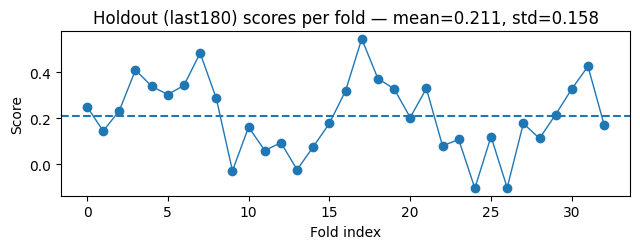

Best Holdout Fold: 17 Score: 0.546175
Worst Holdout Fold: 24 Score: -0.104128
LightGBM Model First Eval Fold Score: 0.251467
LightGBM Model Holdout Score (avg over folds using each model): 0.211


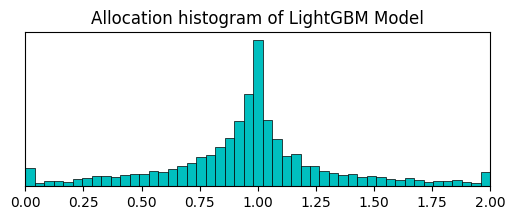

Range of predictions: [0.000000, 2.000000]


In [28]:
# 単純なLightGBMモデルで試す

allocation_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
)

submit_models = cross_validate(allocation_model, label="LightGBM Model")

In [29]:
a

NameError: name 'a' is not defined

### モデル分析

Best Model Holdout Score: 0.546175 (Fold 17)
Worst Model Holdout Score: -0.104128 (Fold 24)


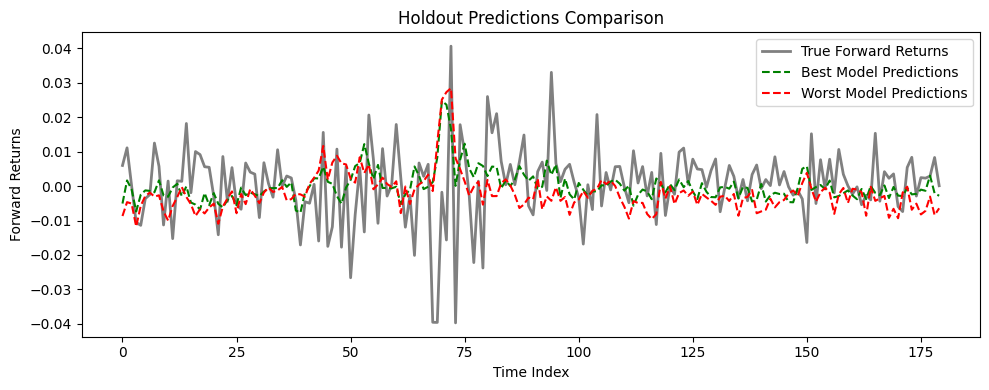

In [30]:
# 1. submit_models からモデル選択
best_model = submit_models[1]  # best_model
worst_model = submit_models[2]  # worst_model

# submit_model.holdout_pred に holdout 予測が入っている
best_pred = best_model["holdout_pred"]
best_strategy = best_model["holdout_strategy"]  # 戦略配分デ

worst_pred = worst_model["holdout_pred"]
worst_strategy = worst_model["holdout_strategy"]  # 戦略配分デ

# 2. best_model, worst_model のスコア確認
best_score = best_model["strategy_score"]
worst_score = worst_model["strategy_score"]
print(
    Fore.GREEN
    + f"Best Model Holdout Score: {best_score:.6f} (Fold {best_model['fold']})"
    + Style.RESET_ALL
)
print(
    Fore.RED
    + f"Worst Model Holdout Score: {worst_score:.6f} (Fold {worst_model['fold']})"
    + Style.RESET_ALL
)

# best_model, worst_modelのpredを可視化，trainの最後180と比較
true = train["forward_returns"].iloc[-180:].to_numpy()
plt.figure(figsize=(10, 4))
plt.plot(true, label="True Forward Returns", color="gray", linewidth=2)
plt.plot(best_pred, label="Best Model Predictions", color="green", linestyle="--")
plt.plot(worst_pred, label="Worst Model Predictions", color="red", linestyle="--")
plt.title("Holdout Predictions Comparison")
plt.xlabel("Time Index")
plt.ylabel("Forward Returns")
plt.legend()
plt.tight_layout()
plt.show()

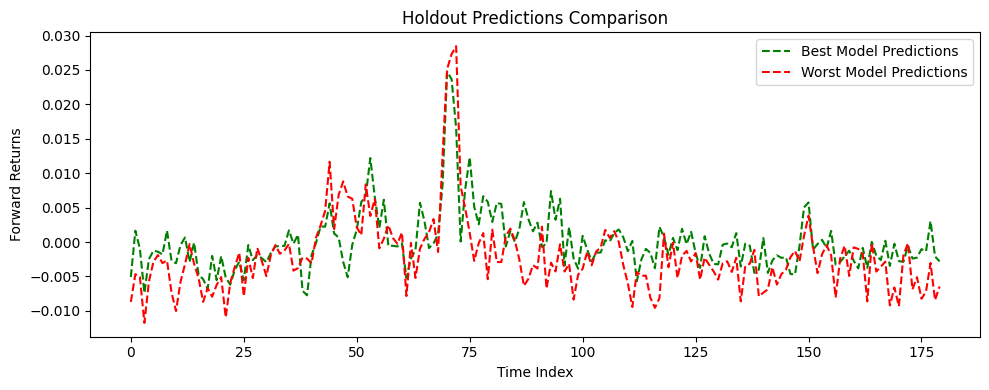

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(best_pred, label="Best Model Predictions", color="green", linestyle="--")
plt.plot(worst_pred, label="Worst Model Predictions", color="red", linestyle="--")
plt.title("Holdout Predictions Comparison")
plt.xlabel("Time Index")
plt.ylabel("Forward Returns")
plt.legend()
plt.tight_layout()
plt.show()

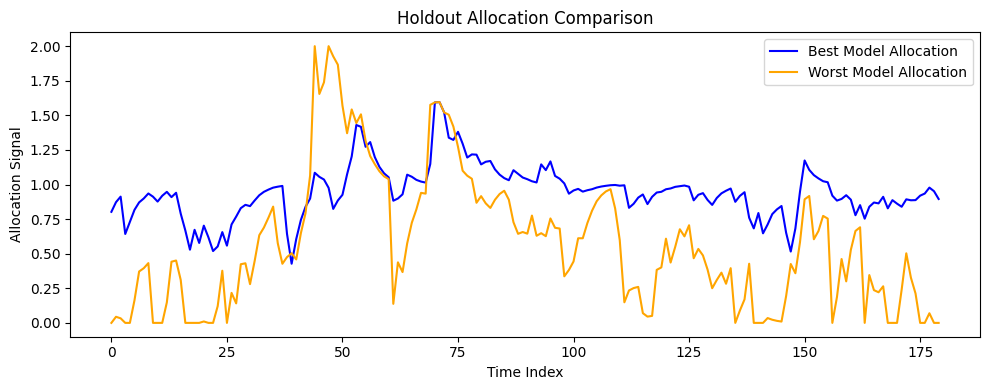

In [32]:
# best_strategy, worst_strategyの配分を可視化
plt.figure(figsize=(10, 4))
plt.plot(
    best_strategy["prediction"],
    label="Best Model Allocation",
    color="blue",
    linestyle="-",
)
plt.plot(
    worst_strategy["prediction"],
    label="Worst Model Allocation",
    color="orange",
    linestyle="-",
)
plt.title("Holdout Allocation Comparison")
plt.xlabel("Time Index")
plt.ylabel("Allocation Signal")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
## kaggleじゃないなら実行を終了
os._exit(0)

NameError: name 'a' is not defined

### Submission
- time-series streaming形式
- Kaggle サーバーから1batchずつ送られるデータからsubmission.parquetを返す
- 返り値検証があるため，指定された形式で返す
- 指定形式
  - 

In [ ]:
def predict(test: pl.DataFrame) -> float:
    """Replace this function with your inference code."""
    test_pd = test.to_pandas()
    # display(test_pd.info())
    if len(test_pd.columns) > 94:
        test_pd = test_pd.drop(
            ["date_id", "is_scored", "lagged_forward_returns", "lagged_risk_free_rate", "lagged_market_forward_excess_returns"],
            axis = 1)

    preds = submit_model.predict(test_pd)
    raw_pred: float = float(preds[0])
    print(f"predict:{raw_pred}")

    # --- 出力（float or ndarray）---
    # KaggleのAPI仕様上、float単体かSeries/DataFrameで返す必要あり float(preds[0]) if len(preds) == 1 else preds　
    return convert_ret_to_signal(raw_pred, ret_signal_params)

In [ ]:
# サーバー上でpredict(test_batch)を動かす
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))